# Wrapped Gaussian Process Regression on Riemannian Manifolds

**Authors:** Tom Szwagier, Arthur Pignet

Corespondence to tom.szwagier@minesparis.psl.eu 


<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


## 1. Introduction and Motivation

Data embedded in a Euclidean space can sometimes benefit from a lower dimensional geometric representation; we then enter the world of manifold-valued datasets. It is the case notably in Medical Imaging with Diffusion Tensor Imaging (DTI) data which comes from Magnetic Resonance Imaging (MRI). This imaging technique allows one to reconstruct bundles of nervous fibers by exposing the tissues to a magnetic field whose outputs enable the computation of a field of diffusion tensors. The diffusion tensors are represented by Symmetric Positive Definite (SPD) matrices characterizing the covariance of the Brownian motion of the water in the brain. The set of SPD being a submanifold embedded in the set of matrices, any quantity computed from DTI data requires to enter the framework of manifold-valued image processing. Thereby, filtering, regularization, interpolation and other processing methods aiming to get information out of that raw data can involve the framework of Riemannian geometry. Other problems in medical image analysis require that framework, like image registration which involves optimization on morphological transformations. These transformations are essentially characterized by a Lie Group structure and allow to compare or align data from different patients, in order to retrieve the deformation of an anatomical structure or to study statistics on its evolution through time.

One of the interests of the manifold modelling in a medical dataset is that it is supposed to well characterize the distribution of meaningful and real medical data. Thus, having operations on the data that preserve the manifold structure *a priori* guarantees that the operations' result still represents meaningful data. This framework is thus interesting when compared to the general approaches for medical image data analysis that give an absolute degree of freedom to the values of the voxels, making them prone to generate non-medical artifacts, like non-SPD matrices in DTI data processing. Above all, with the advent of Deep Learning in medical image analysis, often considered as a black-box, there is an increased risk to miss important parts of the interpretation of the data without this manifold consideration. Moreover, with an interesting representation of the data as a manifold, some meaningful statistics can be obtained out of adapted computations.

However, performing manifold preserving operations is not a trivial task and may require some concepts from Differential Geometry, like Exponential and Logarithmic maps, that locally map a Euclidean tangent space to a curved subset of the manifold, and thus allow to make regular computations on an Euclidean space.

This can become really challenging in the subfield of statistical learning theory that is regression. In the Euclidean space, this topic has been running for centuries, and regression methods are now part of all the basic computer science code libraries, from the simple linear regression, to some complex neural network models.

However, the topic of regression for data on a Riemannian manifold is much more recent and some work is still needed to model data that have highly nonlinear distribution (where here, 'linear' means from the manifold point of view, 'geodesically trended'), while giving powerful uncertainty estimates.

In a recent paper, **[Mallasto2018]** introduce a new algorithm generalizing Gaussian Process Regression (GPR) to Riemannian manifolds, and call it 'Wrapped Gaussian Process Regression' (WGPR). They get good results on manifold-valued medical data (DTI upsampling on the SPD space, regression of patient data on a sphere, and Corpus Callosum ageing on Kendall's shape space), showing the potential of this approach for regression on Riemannian manifolds.

In this Notebook, we propose an implementation of the paper's model. We simulate it on toy datasets consisting in a geodesically-trended sinusoidal curve, with linearly increasing amplitude, SPD-valued bidimensional data, as well as on the real-world diffusion-weighted MRI Stanford HARDI dataset **[Rokem2015]**.

We heavily relied on the libraries Geomstats **[Miolane2020]** for the Riemannian geometry and Scikit-Learn **[Pedregosa2011]** for the Gaussian Processes with hyperparameters optimization.

## 2. Related work

Regression in the Euclidean space, is a classical topic that has been running for centuries, and methods are now part of all the basic computer science code libraries, from the simple linear regression, to some complex neural network models, passing by the Gaussian Processes. This last technique allows to model complex datasets with non-linear trends, based on priors chosen by the user, all of that coming with uncertainty estimates.

However, the topic of regression for data on a Riemannian manifold is much more recent, with a first significant contribution in 2013 called geodesic regression **[Fletcher2013]**. It is the intuitive generalization of linear regression on Riemannian manifolds. This method indeed simply consists in fitting a geodesic curve, parameterized by its intercept $p \in M$ and slope $\nu \in T_pM$ parameters. To do so, the parameters are optimized via the minimization of the sum-of-squared distance between the geodesic and the data, via gradient descent algorithms (contrarily to the linear regression, there is no closed-form analytical solution). Like in the Euclidean case, statistics can be computed on the regression, like the $r^2$ statistic, to quantify the impact of a variable on another. Fletcher illustrates that on Kendall's shape space by studying the impact of the age on the Corpus Callosum.

With these tools, several advances have been made in the past decade. However, just as a lot of regular data does not follow a linear trend in euclidean spaces, a lot of manifold valued medical data does not follow a geodesic trend. In order to model those "non-geodesic" relationships, some tools from non-linear regression have been generalized to manifolds around the 2010's: polynomial regression **[Hinkle2012]** and kernel-based approaches **[Banerjee2015, Davis2007]**. However, those methods exhibit the same limitation as in the Euclidean framework, they do not provide powerful uncertainty estimates, contrary to geodesic regression.
A well known method to take into account the noise in the observations as well as computing interesting uncertainty estimates in the linear framework is Gaussian Process Regression (GPR). That method considers the dataset as sampled from a jointly multivariate Gaussian distribution and makes use of Gaussian conditioning to infer new values. Understanding the impact of such a method in the euclidean space, this paper's authors proposed to generalize GPR to manifold-valued data, calling them Wrapped Gaussian Processes (WGP), and showing their effective application on manifold-valued medical data (DTI upsampling on the SPD space, regression of patient data on a sphere, and Corpus Callosum ageing on Kendall's shape space).

## 3. Implementation of Wrapped Gaussian Process Regression (WGPR)

### Algorithm 

In order to introduce wrapped Gaussian Process Regression on Riemannian manifolds, we first need to extend the notion of a Multivariate Gaussian distribution on a manifold. **[Mallasto2018]** defines a Wrapped Gaussian Distribution (WGD) with the basepoint $\mu_{\mathcal{N}_M} = \mu$ and the tangent space covariance $Cov_{\mathcal{N}_M} = K$ as the push-forward of a Multivariate Gaussian by the Exponential map: 

$$
    {(Exp_{\mu})}_\#(\mathcal{N}(0,K)).
$$

We note: $X \sim \mathcal{N}_M(\mu,K))$.
The idea between WGD is very intuitive: to sample from a WGD, we sample $x$ from a $\mathcal{N}(0,K)$, representing a vector in the tangent space of a certain $\mu \in M$ and then map the resulting vector to a point in M with the Exp map.

Some calculus combining a Multivariate Gaussian distributions lemma and basic Riemannian geometry allows the authors to derive the formula of the conditional distribution of two jointly WGD random variables. By taking the strong assumption of the infinite injectivity radius of the exponential map on the manifold, the authors derived a much simpler expression that they will use in all their experiments:
\begin{align} X_{1}& \vert (X_{2}=p_{2}) \sim(\mathrm{Exp}_{\mu_{1}})_{\#}(\mathcal{N}(\mu_{{\mathrm{Log}}_{\mu_{2}}(p_{2})}, K_{{\mathrm{Log}}_{\mu_{2}}(p_{2})}))
\end{align}

This powerful formula allows to infer the estimates along with uncertainty of Gaussian Processes on manifolds, under the hypotheses introduced right after by the authors. 

The authors are then able to define Wrapped Gaussian Processes on a manifold $M$ as a collection of random $f\in M$ with every finite subcollection jointly following a wrapped Gaussian distribution, i.e. \begin{equation} f\sim(\mathrm{Exp}_{m})_{\#}(\mathcal{GP}(0,\ k)) \end{equation} where \begin{align} m(\omega)&: =\mu_{\mathcal{N}_{M}}(f(\omega))\\ k(\omega,\ \omega')&: =\mathrm{Cov}_{\mathcal{N}_{M}}(f(\omega),\ f(\omega'))\\  \end{align} respectively denoted basepoint function (BPF) and *tangent space convariance function (TSCF)*. Given a dataset $D$ they derive a simple formula for the inference of WGPR on Riemannian manifolds:
\begin{align} p_{\ast}\vert p& \sim(\mathrm{Exp}_{m_{\ast}})_{\#}(\mathcal{N}(\mu_{\ast},\Sigma_{\ast})), \\ \mu_{\ast}& =k_{\ast}k^{-1}{\mathrm{Log}}_{m}p,\\ \Sigma_{\ast}& =k_{\ast\ast}-k_{\ast}k^{-1}k_{\ast}^{T}\end{align}

That formula leads to a pretty simple algorithm called "WGP regression".

------

Inputs : $D_{M}=\{(x_{i},p_{i}) \vert x_{i}\in \mathbb{R}^{l},\ p_{i}\in M,\ i=1,\ldots,\ N\}$
 
- Compute the tangent dataset: $\quad D_{T_m M}=\{(x,Log_{m(x)}(p) \vert ,\forall(x,p) \in D_{M} \}$
-  Select a kernel $k$, and optimize its hyperparameters.
- Carry out a GP regression, with GP prior $(0,k)$ on $D_{T_m M}$, yiedling the mean and covariance $(\mu_*, \Sigma_*)$ for input $x_*$
- Pushforward the prediction distribution $p^* \vert p \sim(Exp_{prior(x_*})_\#(\mathcal{N}(\mu_*, \Sigma_*) $

Outputs: $p^* \vert p$

------

The push-forward operator is not a issue in practice, as we only have to draw a sample from the posterior distribution in the tangent space, and then take the Exp of the sample, using the basepoint given by the prior function. However, and this is the subject of the Remark 3 of the article, the Exp of the mean of the GP is not necessarily the Fréchet mean of the a posterior law. It is still the maximum a priori estimate, so we will use it as a deterministic prediction, however not as the mean. 

### Implementation
WGPR was recently added to geomstats after we made a pull request.

The code is accessible here -> https://github.com/geomstats/geomstats/blob/master/geomstats/learning/wrapped_gaussian_process.py

And unit-tests are here -> https://github.com/geomstats/geomstats/blob/master/tests/tests_geomstats/test_wrapped_gaussian_process.py

### Imports

In [1]:
!pip install dipy

In [2]:
!pip install geomstats

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import train_test_split
os.environ["GEOMSTATS_BACKEND"] = "pytorch" # "tensorflow"
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.frechet_mean import FrechetMean, variance
from geomstats.learning.geodesic_regression import GeodesicRegression

INFO: NumExpr defaulting to 2 threads.
INFO: Using pytorch backend


In [4]:
r"""Wrapped Gaussian Process.

Lead author: Arthur Pignet

Extension of Gaussian Processes to Riemannian Manifolds,
introduced in [Mallasto]_.

References
----------
..[Mallasto]   Mallasto, A. and Feragen, A.
            “Wrapped gaussian process
            regression on riemannian manifolds.”
            IEEE/CVF
Conference on Computer Vision and Pattern Recognition (2018)

"""

from sklearn.base import BaseEstimator, MultiOutputMixin, RegressorMixin
from sklearn.gaussian_process import GaussianProcessRegressor


class WrappedGaussianProcess(MultiOutputMixin, RegressorMixin, BaseEstimator):
    r"""Wrapped Gaussian Process.

    The implementation is based on the algorithm 4 of [1].

    Parameters
    ----------
    space : Manifold
        Manifold.
    metric : RiemannianMetric
        Riemannian metric.
    prior : function
        Associate to each input a manifold valued point.
     kernel : kernel instance, default=None
        The kernel specifying the covariance function of the GP. If None is
        passed, the kernel ``ConstantKernel(1.0, constant_value_bounds="fixed")
        * RBF(1.0, length_scale_bounds="fixed")`` is used as default. Note that
        the kernel hyperparameters are optimized during fitting unless the
        bounds are marked as "fixed".
    alpha : float or ndarray of shape (n_samples,), default=1e-10
        Value added to the diagonal of the kernel matrix during fitting.
        This can prevent a potential numerical issue during fitting, by
        ensuring that the calculated values form a positive definite matrix.
        It can also be interpreted as the variance of additional Gaussian
        measurement noise on the training observations. Note that this is
        different from using a `WhiteKernel`. If an array is passed, it must
        have the same number of entries as the data used for fitting and is
        used as datapoint-dependent noise level. Allowing to specify the
        noise level directly as a parameter is mainly for convenience and
        for consistency with :class:`~sklearn.linear_model.Ridge`.
    optimizer : "fmin_l_bfgs_b" or callable, default="fmin_l_bfgs_b"
        Can either be one of the internally supported optimizers for optimizing
        the kernel's parameters, specified by a string, or an externally
        defined optimizer passed as a callable. If a callable is passed, it
        must have the signature::
            def optimizer(obj_func, initial_theta, bounds):
                # * 'obj_func': the objective function to be minimized, which
                #   takes the hyperparameters theta as a parameter and an
                #   optional flag eval_gradient, which determines if the
                #   gradient is returned additionally to the function value
                # * 'initial_theta': the initial value for theta, which can be
                #   used by local optimizers
                # * 'bounds': the bounds on the values of theta
                ....
                # Returned are the best found hyperparameters theta and
                # the corresponding value of the target function.
                return theta_opt, func_min
        Per default, the L-BFGS-B algorithm from `scipy.optimize.minimize`
        is used. If None is passed, the kernel's parameters are kept fixed.
        Available internal optimizers are: `{'fmin_l_bfgs_b'}`.
    n_restarts_optimizer : int, default=0
        The number of restarts of the optimizer for finding the kernel's
        parameters which maximize the log-marginal likelihood. The first run
        of the optimizer is performed from the kernel's initial parameters,
        the remaining ones (if any) from thetas sampled log-uniform randomly
        from the space of allowed theta-values. If greater than 0, all bounds
        must be finite. Note that `n_restarts_optimizer == 0` implies that one
        run is performed.
    copy_X_train : bool, default=True
        If True, a persistent copy of the training data is stored in the
        object. Otherwise, just a reference to the training data is stored,
        which might cause predictions to change if the data is modified
        externally.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation used to initialize the centers.
        Pass an int for reproducible results across multiple function calls.

    [1] Mallasto, A. and Feragen, A. Wrapped gaussian process
    regression on riemannian manifolds. In 2018 IEEE/CVF
    Conference on Computer Vision and Pattern Recognition
    """

    def __init__(
        self,
        space,
        metric,
        prior,
        kernel=None,
        *,
        alpha=1e-10,
        optimizer="fmin_l_bfgs_b",
        n_restarts_optimizer=0,
        copy_X_train=True,
        random_state=None,
    ):
        if metric is None:
            metric = space.metric
        self.metric = metric
        self.space = space
        self.prior = prior
        self.copy_X_train = copy_X_train

        self.y_train_ = None
        self.tangent_y_train_ = None
        self.y_train_shape_ = None

        self._euclidean_gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=alpha,
            optimizer=optimizer,
            n_restarts_optimizer=n_restarts_optimizer,
            normalize_y=False,
            copy_X_train=copy_X_train,
            random_state=random_state,
        )

        self.__dict__.update(self._euclidean_gpr.__dict__)
        self.log_marginal_likelihood = self._euclidean_gpr.log_marginal_likelihood

    def _get_tangent_targets(self, X, y):
        """Compute the tangent targets, using the provided prior.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Feature vectors or other representations of training data.
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
        or (n_samples, n1_targets, n2_targets) for
        matrix-valued targets.
            Target values. The target must belongs to the manifold space

        Returns
        -------
        tangent_y : array-like of shape (n_samples,) or (n_samples, n_targets)
        or (n_samples, n1_targets, n2_targets)
                Target projected on the associated (by the prior) tangent space.
        """
        base_points = self.prior(X)
        return self.metric.log(y, base_point=base_points)

    def fit(self, X, y):
        """Fit Wrapped Gaussian process regression model.

        The Wrapped Gaussian process is fit through the following steps:

        - Compute the tangent dataset using the prior
        - Fit a Gaussian process regression on the tangent dataset
        - Store the resulting euclidean Gaussian process

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Feature vectors or other representations of training data.
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
        or (n_samples, n1_targets, n2_targets)
            Target values. The target must belongs to the manifold space

        Returns
        -------
        self : object
            WrappedGaussianProcessRegressor class instance.
        """
        if not gs.all(self.space.belongs(y)):
            raise AttributeError("The target values must belongs to the given space")

        # compute the tangent dataset using the prior
        tangent_y = self._get_tangent_targets(X, y)
        self.y_train_shape_ = y.shape[
            1:
        ]  # this is really useful when the samples are matrices, or tensor of dim>1
        tangent_y = gs.reshape(tangent_y, (y.shape[0], -1))  # flatten the samples.
        # fit a gpr on the tangent dataset

        self._euclidean_gpr.fit(X, tangent_y)
        # update the attributes of the wgpr using the new attributes of the gpr

        self.__dict__.update(self._euclidean_gpr.__dict__)
        self.y_train_ = y
        self.tangent_y_train_ = tangent_y  # = self._euclidean_gpr.y_train_

        return self

    def predict(self, X, return_tangent_std=False, return_tangent_cov=False):
        """Predict using the Gaussian process regression model.

        A fitted Wrapped Gaussian process can be use to predict values
        through the following steps:

            - Use the stored Gaussian process regression on the dataset to
                return tangent predictions
            - Compute the base-points using the prior
            - Map the tangent predictions on the manifold via the metric's exp
                with the base-points yielded by the prior

        We can also predict based on an unfitted model by using the GP prior.
        In addition to the mean of the predictive distribution, optionally also
        returns its standard deviation (`return_std=True`) or covariance
        (`return_cov=True`). Note that at most one of the two can be requested.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Query points where the GP is evaluated.
        return_tangent_std : bool, default=False
            If True, the standard-deviation of the predictive distribution on at
            the query points in the tangent space is returned along with the mean.
        return_tangent_cov : bool, default=False
            If True, the covariance of the joint predictive distribution at
            the query points in the tangent space is returned along with the mean.

        Returns
        -------
        y_mean : ndarray of shape (n_samples,) or (n_samples, n_targets)
            Mean of predictive distribution a query points.
        y_std : ndarray of shape (n_samples,) or (n_samples, n_targets), optional
            Standard deviation of predictive distribution at query points in
            the tangent space.
            Only returned when `return_std` is True.
        y_cov : ndarray of shape (n_samples, n_samples) or \
                (n_samples, n_samples, n_targets), optional
            Covariance of joint predictive distribution a query points
            in the tangent space.
            Only returned when `return_cov` is True.
            In the case where the target is matrix valued,
            return the covariance of the vectorized prediction.
        """
        if return_tangent_cov:
            tangent_means, tangent_cov = self._euclidean_gpr.predict(
                X, return_cov=True, return_std=False
            )
            tangent_means = gs.reshape(
                gs.cast(tangent_means, dtype=X.dtype),
                (X.shape[0], *self.y_train_shape_),
            )
            tangent_cov = gs.cast(
                tangent_cov, dtype=X.dtype
            )  # covariance of the vectorized predictions.

            base_points = self.prior(X)
            y_mean = self.metric.exp(tangent_means, base_point=base_points)
            result = (y_mean, tangent_cov)

        elif return_tangent_std:
            tangent_means, tangent_std = self._euclidean_gpr.predict(
                X, return_cov=False, return_std=True
            )
            base_points = self.prior(X)
            tangent_means = gs.reshape(
                gs.cast(tangent_means, dtype=X.dtype),
                (X.shape[0], *self.y_train_shape_),
            )
            tangent_std = gs.cast(tangent_std, dtype=X.dtype)

            y_mean = self.metric.exp(tangent_means, base_point=base_points)
            result = (y_mean, tangent_std)

        else:
            tangent_means = self._euclidean_gpr.predict(
                X, return_cov=False, return_std=False
            )
            base_points = self.prior(X)
            tangent_means = gs.reshape(
                gs.cast(tangent_means, dtype=X.dtype),
                (X.shape[0], *self.y_train_shape_),
            )
            y_mean = self.metric.exp(tangent_means, base_point=base_points)
            result = y_mean

        return result

    def sample_y(self, X, n_samples=1, random_state=0):
        """Draw samples from Wrapped Gaussian process and evaluate at X.

        A fitted Wrapped Gaussian process can be use to sample
        values through the following steps:

            - Use the stored Gaussian process regression on the dataset
                to sample tangent values
            - Compute the base-points using the prior
            - Flatten (and repeat if needed) both the base-points and the
                tangent samples to benefit from vectorized computation.
            - Map the tangent samples on the manifold via the metric's exp with the
                flattened and repeated base-points yielded by the prior

        Parameters
        ----------
        X : array-like of shape (n_samples_X, n_features) or list of object
            Query points where the WGP is evaluated.
        n_samples : int, default=1
            Number of samples drawn from the Wrapped Gaussian process per query point.
        random_state : int, RandomState instance or None, default=0
            Determines random number generation to randomly draw samples.
            Pass an int for reproducible results across multiple function
            calls.

        Returns
        -------
        y_samples : ndarray of shape (n_samples_X, n_samples), or \
            (n_samples_X, n_targets, n_samples)
            Values of n_samples samples drawn from wrapped Gaussian process and
            evaluated at query points.
        """
        tangent_samples = self._euclidean_gpr.sample_y(X, n_samples, random_state)
        tangent_samples = gs.cast(tangent_samples, dtype=X.dtype)
        # flatten the samples
        tangent_samples = gs.reshape(
            gs.transpose(tangent_samples, [0, 2, 1]), (-1, *self.y_train_shape_)
        )

        # generate the base_points
        base_points = self.prior(X)
        # repeat the base points in order to match the tangent samples
        base_points = gs.repeat(gs.expand_dims(base_points, 2), n_samples, axis=2)
        # flatten the base_points
        base_points = gs.reshape(
            gs.transpose(base_points, [0, 2, 1]), (-1, *self.y_train_shape_)
        )

        # get the flattened samples
        y_samples = self.metric.exp(tangent_samples, base_point=base_points)
        y_samples = gs.transpose(
            gs.reshape(y_samples, (X.shape[0], n_samples, *self.y_train_shape_)),
            [0, 2, 1],
        )

        return y_samples

## 4. Test on Synthetic Datasets and Benchmark

### Generate toy dataset on the 2-sphere

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


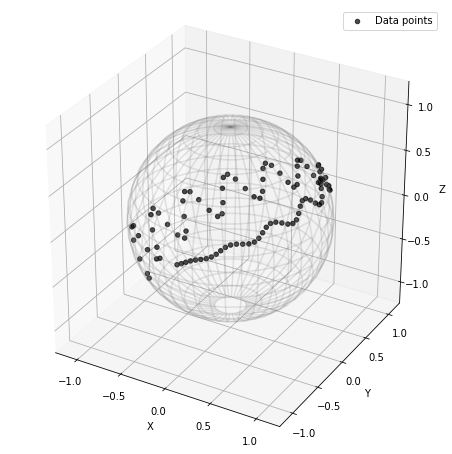

In [5]:
# Define the space and metric
DIM = 2
SPACE = Hypersphere(dim=DIM)
EMBEDDING_DIM = SPACE.embedding_space.dim
METRIC = SPACE.metric
gs.random.seed(0)

# Generate sinusoidal data on the sphere

# First generate the geodesic
n_samples = 100
X = gs.linspace(0, 1.5 * gs.pi, n_samples)
intercept = gs.array([0, -1., 0], dtype=gs.float64)
coef = gs.array([1, 0, 0.5], dtype=gs.float64)
y = METRIC.exp(X[:, None] * coef, base_point=intercept)

# Then add orthogonal sinusoidal oscillations
o = 1 / 20 * gs.array([-0.5, 0, 1], dtype=gs.float64)
o = SPACE.to_tangent(o, base_point=y)
s = X[:, None] * np.sin(5 * np.pi * X[:, None])
y = METRIC.exp(s * o, base_point=y)

fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(y, space='S2', color='black', alpha=0.7, label='Data points')
ax.set_box_aspect([1, 1, 1])
ax.legend()
plt.show()

In [6]:
# Generate training set
X_train, _, y_train, _ = train_test_split(gs.expand_dims(X,1), y, train_size=0.3, random_state=42)

# Generate thinner time grid for "smooth" curve prediction at inference
X_inference = gs.linspace(0., 1.5*gs.pi, n_samples * 10)
f_true = METRIC.exp(X_inference[:, None] * coef, base_point=intercept)
o = 1 / 20 * gs.array([-0.5, 0, 1], dtype=gs.float64)
o = SPACE.to_tangent(o, base_point=f_true)
s = X_inference[:, None] * gs.sin(5 * gs.pi * X_inference[:, None])
f_true = METRIC.exp(s * o, base_point=f_true)
f_true = np.squeeze(f_true)

### Define prior and kernel parameters

         Current function value: 0.225104
         Iterations: 26
         Function evaluations: 74
         Gradient evaluations: 67


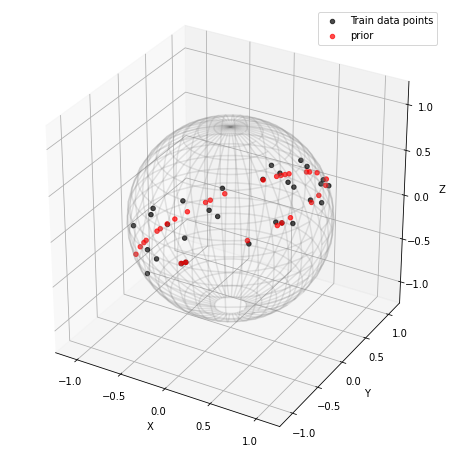

In [7]:
# Geodesic regression prior
gr = GeodesicRegression(SPACE, center_X=False, method="extrinsic", verbose=True)
gr.fit(gs.squeeze(X_train), y_train, compute_training_score=True)
intercept_hat, coef_hat = gr.intercept_, gr.coef_
prior = lambda X: METRIC.exp(X * coef_hat, base_point=intercept_hat)

# RBF Kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Plot the prior
fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(y_train, space='S2', color='black', alpha=0.7, label='Train data points')
ax.scatter(prior(X_train)[:, 0], prior(X_train)[:, 1], prior(X_train)[:, 2], color='red', alpha=.7, label='prior')
ax.set_box_aspect([1, 1, 1])
ax.legend()
plt.show()

### Fit WGPR

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:13

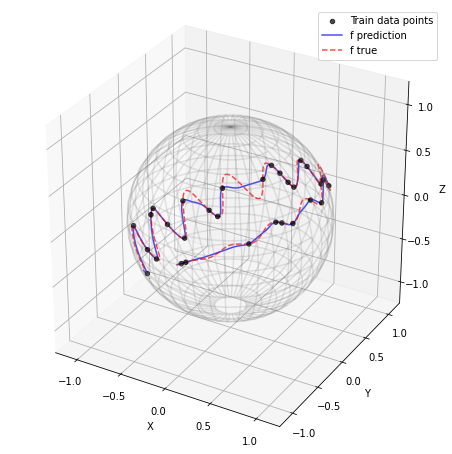

In [8]:
# WGPR
wgp = WrappedGaussianProcess(space=SPACE, metric=METRIC, prior=prior, kernel=kernel)
wgp.fit(X_train, y_train)
f_pred = wgp.predict(X_inference.reshape(-1, 1))

fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(y_train, space='S2', color='black', alpha=0.7, label='Train data points')
ax.plot(f_pred[:, 0], f_pred[:, 1], f_pred[:, 2], color='blue', alpha=.7, label='f prediction')
ax.plot(f_true[:, 0], f_true[:, 1], f_true[:, 2], color='red', ls="--", alpha=.7, label='f true')
ax.set_box_aspect([1, 1, 1])
ax.legend()
plt.show()

### Benchmark against other methods
Here we decide to compare WGPR to Euclidean GPR in term of accuracy. We could also compare it to geodesic regression but it is evident, in terms of mean squared error, that geodesic regression is worse than WGPR.

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


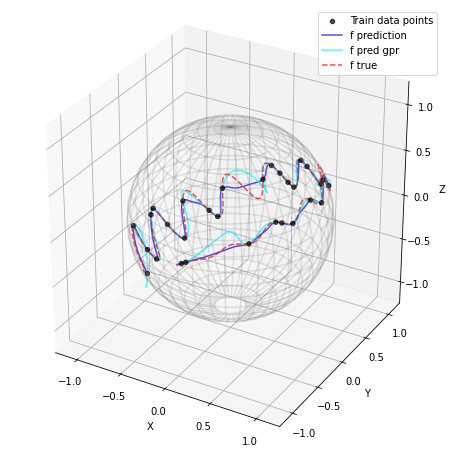

In [9]:
# Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train,y_train)
f_pred_gpr = gpr.predict(X_inference.reshape(-1, 1))
f_pred_gpr = gs.array(f_pred_gpr)

fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(y_train, space='S2', color='black', alpha=0.7, label='Train data points')
ax.plot(f_pred[:, 0], f_pred[:, 1], f_pred[:, 2], color='blue', alpha=.7, label='f prediction')
ax.plot(f_pred_gpr[:, 0], f_pred_gpr[:, 1], f_pred_gpr[:, 2], color='cyan', alpha=.7, label='f pred gpr')
ax.plot(f_true[:, 0], f_true[:, 1], f_true[:, 2], color='red', ls="--", alpha=.7, label='f true')
ax.set_box_aspect([1, 1, 1])
ax.legend()
plt.show()

One first striking observation is that, without any consideration on the prediction error, the GPR predictions seem to "go out of the manifold". Indeed, although WGPR is designed to make predictions inside the manifold, GPR doesn't have *a priori* that constraint. Let us check whether the predictions are on the sphere.

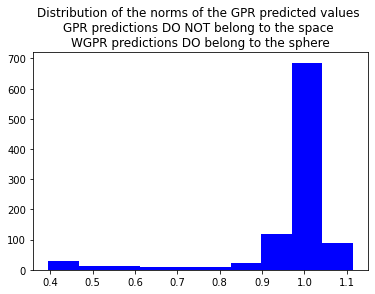

In [10]:
# Plot distribution of euclidean norms of the predictions for GPR. 
plt.hist(np.linalg.norm(f_pred_gpr, axis=1), color = "blue")
plt.title(f"Distribution of the norms of the GPR predicted values \n"
          f"GPR predictions {'DO' if (SPACE.belongs(f_pred_gpr).all()) else 'DO NOT'} belong to the space \n"
          f"WGPR predictions {'DO' if (SPACE.belongs(f_pred).all()) else 'DO NOT'} belong to the sphere")
plt.show()

Let us moreover compute the Mean Squared Error for WGPR and GPR.

In [11]:
print("Mean Squared Error for WGPR = ", np.mean(np.linalg.norm(f_pred - f_true, axis=1)**2))
print("Mean Squared Error for GPR = ", np.mean(np.linalg.norm(f_pred_gpr - f_true, axis=1)**2))

Mean Squared Error for WGPR =  0.0027332956
Mean Squared Error for GPR =  0.022029711


The WGPR predictions are way better in terms of Mean Squared Error. 

We continue in this toy dataset to investigate the overhead in term of computational time and memory of our WGPR's implementation against the standart scikit-learn implementation. As the role of the prior is different in the WGPR, we want to include its computation in the running time of our WGPR. However, this prior computation time is obviously very prior-dependant. We will thus compare the computationnal time of prior+WGPR, WGPR and euclidean GPR.

In [12]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

def get_prior(X_train, y_train):
  # compute and return a geodsic regression that will be used as a prior. 
  gr = GeodesicRegression(SPACE, center_X=False, method="extrinsic", verbose=False)
  gr.fit(gs.squeeze(X_train), y_train, compute_training_score=True)
  intercept_hat, coef_hat = gr.intercept_, gr.coef_
  prior = lambda X: METRIC.exp(X * coef_hat, base_point=intercept_hat)
  return prior

def create_and_fit_wgpr(prior, X_train, y_train):
  wgp = WrappedGaussianProcess(space=SPACE, metric=METRIC, prior=prior, kernel=kernel)
  wgp.fit(X_train, y_train)
  return wgp

def wgpr_inference(wgpr, X_inference):
  f_pred = wgpr.predict(X_inference.reshape(-1, 1))

def create_and_fit_gpr(X_train, y_train):
  gpr = GaussianProcessRegressor(kernel=kernel)
  gpr.fit(X_train,y_train)
  return gpr

def gpr_inference(gpr, X_inference):
  f_pred_gpr = gpr.predict(X_inference.reshape(-1, 1))
  f_pred_gpr = gs.array(f_pred_gpr) # the wgpr is doing this conversion internally. In a workflow where you want to work in pytorch this operation needs to be done and thus to be included for fairness. 

def generate_dataset(n_samples):
  '''
  Generate a dataset of n_samples in the same way that described above. The amount of train points and inference point is the same. 
  '''
  X = gs.linspace(0, 1.5 * gs.pi, 2*n_samples) # the number of point is doubled as we will randomly select 50 % of them.
  intercept = gs.array([0, -1., 0], dtype=gs.float64)
  coef = gs.array([1, 0, 0.5], dtype=gs.float64)
  y = METRIC.exp(X[:, None] * coef, base_point=intercept)
  
  o = 1 / 20 * gs.array([-0.5, 0, 1], dtype=gs.float64)
  o = SPACE.to_tangent(o, base_point=y)
  s = X[:, None] * np.sin(5 * np.pi * X[:, None])
  y = METRIC.exp(s * o, base_point=y)
  X_train, _, y_train, _ = train_test_split(gs.expand_dims(X,1), y, train_size=0.5, random_state=42)

  X_inference = gs.linspace(0., 1.5*gs.pi, n_samples) # same number of samples
  f_true = METRIC.exp(X_inference[:, None] * coef, base_point=intercept)
  o = 1 / 20 * gs.array([-0.5, 0, 1], dtype=gs.float64)
  o = SPACE.to_tangent(o, base_point=f_true)
  s = X_inference[:, None] * gs.sin(5 * gs.pi * X_inference[:, None])
  f_true = METRIC.exp(s * o, base_point=f_true)
  f_true = np.squeeze(f_true)

  return X_train, y_train, X_inference, f_true


In [13]:
from time import time

n_repeat = 4
n_samples_tested = [100, 300, 800, 1200]
prior_time = np.empty((len(n_samples_tested), n_repeat))
gpr_fit_time = np.empty((len(n_samples_tested), n_repeat))
gpr_predict_time = np.empty((len(n_samples_tested), n_repeat))
wgpr_fit_time = np.empty((len(n_samples_tested), n_repeat))
wgpr_predict_time = np.empty((len(n_samples_tested), n_repeat))

for i, n_samples in enumerate(n_samples_tested): 
  print(f'nb of samples: {n_samples}')
  X_train, y_train, X_inference, f_true = generate_dataset(n_samples)
  for j in range(n_repeat):
      print(f'repetition {j}/{n_repeat}')
      chrono = time()
      prior = get_prior(X_train, y_train)
      prior_time[i,j] = time() - chrono 

      chrono = time()
      wgpr = create_and_fit_wgpr(prior, X_train, y_train)
      wgpr_fit_time[i,j] = time() - chrono 

      chrono = time()
      wgpr_inference(wgpr, X_inference)
      wgpr_predict_time[i,j] = time() - chrono 

      del wgpr # free memory

      chrono = time()
      gpr = create_and_fit_gpr(X_train, y_train)
      gpr_fit_time[i,j] = time() - chrono 

      chrono = time()
      gpr_inference(gpr, X_inference)
      gpr_predict_time[i,j] = time() - chrono 

      del gpr 

nb of samples: 100
repetition 0/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 1/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 2/4
repetition 3/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


nb of samples: 300
repetition 0/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 1/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 2/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 3/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


nb of samples: 800
repetition 0/4
repetition 1/4
repetition 2/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 3/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


nb of samples: 1200
repetition 0/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 1/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 2/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


repetition 3/4


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


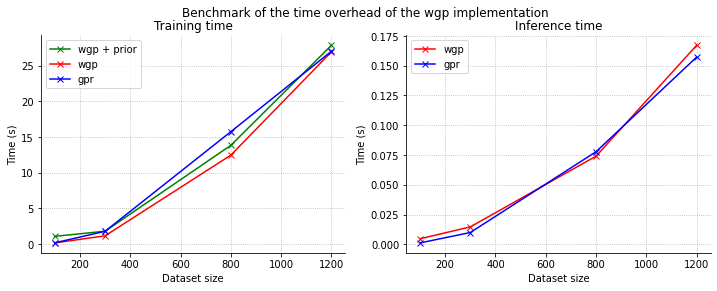

In [14]:
f, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title('Training time')
ax[0].plot(n_samples_tested, np.mean(prior_time+wgpr_fit_time, axis=1), 'x-',color='green', label='wgp + prior')
ax[0].plot(n_samples_tested, wgpr_fit_time.mean(axis=1),'x-',color='red', label='wgp')
ax[0].plot(n_samples_tested, gpr_fit_time.mean(axis=1),'x-',color='blue', label='gpr')
ax[0].set_ylabel('Time (s)')
ax[0].set_xlabel('Dataset size')
ax[0].grid(ls=':')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend()

ax[1].set_title('Inference time')
ax[1].plot(n_samples_tested, wgpr_predict_time.mean(axis=1),'x-',color='red', label='wgp')
ax[1].plot(n_samples_tested, gpr_predict_time.mean(axis=1),'x-',color='blue', label='gpr')
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Dataset size')
ax[1].grid(ls=':')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].legend()
plt.suptitle("Benchmark of the time overhead of the wgp implementation")
plt.show()

As a conclusion, WGPR seem to have a lot of advantages over top-level nonlinear Euclidean methods like GPR, for manifold-valued data on the 2-sphere. Let's illustrate it now on another kind of manifold-valued data: SPD-valued data.

### Toy dataset on the SPD manifold

In [15]:
# Helper function for SPD matrices plot. Source: https://colab.research.google.com/drive/1gCpSOoZ6odPmDQxYwki4koYqciaolRQw

from matplotlib.colors import LightSource
from matplotlib import cm
# your ellispsoid and center in matrix form
A = np.array([[1,0,0],[0,2,0],[0,0,2]])
center = [0,0,0]

def plot_ellipsoid(ax, mu, K):
    U, s, rot =  np.linalg.svd(K)
    smax = np.max(s)
    max_ind = np.argmax(s)
    s = 0.025* s / smax #The scaling is just for nicer plots
    
    c = np.abs(rot[max_ind])
    #c = c/np.sum(c)

    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
    x = s[0] * np.outer(np.cos(u), np.sin(v))
    y = s[1] * np.outer(np.sin(u), np.sin(v))
    z = s[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rot) + mu
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=c)

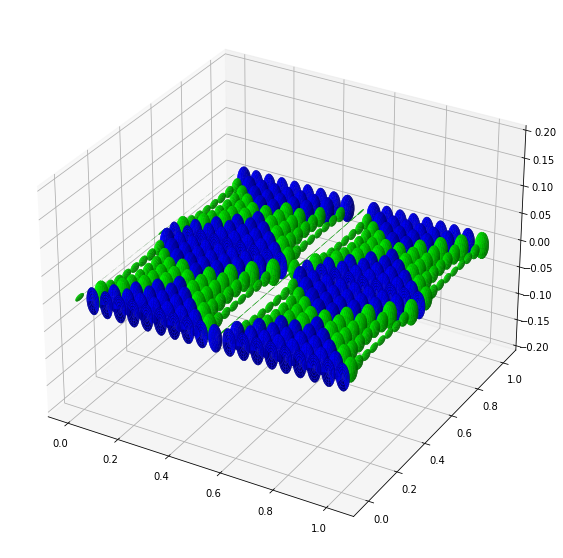

In [16]:
# Create Toy SPD dataset
from geomstats.geometry.spd_matrices import SPDMatrices

# Define the space and metric
DIM = 3
SPACE = SPDMatrices(DIM)
METRIC = SPACE.metric
gs.random.seed(0)


n_samples = 20
t = gs.linspace(0, 1, n_samples)
X = gs.array(gs.meshgrid(t, t)).T.reshape(-1, 2)
y = gs.array([gs.eye(3)* gs.array(np.diag(gs.array([(5*gs.abs(gs.sin(6*x[0])) +1e-2)*n_samples, 1, (5*gs.abs(gs.sin(6*x[0])) +1e-2)*n_samples]))) * gs.array(np.diag(gs.array([1, 5 * (gs.abs(gs.sin(6*x[1]))+1e-2)*n_samples, 1]))) for x in X]).reshape(len(X), 3, 3)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X)):
    plot_ellipsoid(ax, [X[i, 0], X[i, 1], 0], y[i])

ax.set_zlim(-.2,.2)
plt.show()

In [17]:
# Generate training set
X_train, y_train = gs.copy(X), gs.copy(y)

# Generate thinner time grid for "smooth" curve prediction at inference
n_samples_inference = 30
t_inference = gs.linspace(0, 1, n_samples_inference)
X_inference = gs.array(gs.meshgrid(t_inference, t_inference)).T.reshape(-1, 2)
f_true = gs.array([gs.eye(3)* gs.array(np.diag(gs.array([(5*gs.abs(gs.sin(6*x[0])) +1e-2)*n_samples, 1, (5*gs.abs(gs.sin(6*x[0])) +1e-2)*n_samples]))) * gs.array(np.diag(gs.array([1, 5 * (gs.abs(gs.sin(6*x[1]))+1e-2)*n_samples, 1]))) for x in X_inference]).reshape(len(X_inference), 3, 3)

In [18]:
# We use Frechet Mean as a priori
mean = FrechetMean(metric=METRIC)
mean.fit(y_train)
mean_estimate = mean.estimate_
prior = lambda X: mean_estimate
# RBF Kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(.1, (1e-2, 1e-0))

In [19]:
# WGPR
wgp = WrappedGaussianProcess(space=SPACE, metric=METRIC, prior=prior, kernel=kernel)
wgp.fit(X_train, y_train)
y_inference_pred = wgp.predict(X_inference)
print("Mean Squared Error (Frobenius) for WGPR = ", np.mean(np.linalg.norm(y_inference_pred - f_true, axis=(1,2))**2))

# Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train,y_train.reshape(-1, 3*3))  # reshaping because sklearn estimator doesn't accept n_dim > 2. Our implementation of the WGPR handles it internally. 
y_inference_pred_gpr = gpr.predict(X_inference)
y_inference_pred_gpr = y_inference_pred_gpr.reshape(-1, 3, 3)
print("Mean Squared Error (Frobenius) for GPR = ", np.mean(np.linalg.norm(gs.array(y_inference_pred_gpr) - f_true, axis=(1,2))**2))

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Mean Squared Error (Frobenius) for WGPR =  2951.938
Mean Squared Error (Frobenius) for GPR =  10015.361


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


We get way better results in terms of MSE for WGPR.

## 5. Real-world diffusion-weighted MRI Stanford HARDI dataset **[Rokem2015]**

Now we use DWI data, that can be represented as a SPD-valued 3D image. We extract a 2D slice from the image using the pipeline from the `dipy` library website: https://dipy.org/documentation/1.4.1./examples_built/reconst_dti/#example-reconst-dti 

In [20]:
# Convert the nifti image into a SPD one
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames
from dipy.segment.mask import median_otsu

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

INFO: Creating new folder /root/.dipy/stanford_hardi
INFO: Downloading "HARDI150.nii.gz" to /root/.dipy/stanford_hardi


  0%|          | 0/5578 [00:00<?, ? MB/s]

INFO: Downloading "HARDI150.bval" to /root/.dipy/stanford_hardi


  0%|          | 0/1 [00:00<?, ? MB/s]

INFO: Downloading "HARDI150.bvec" to /root/.dipy/stanford_hardi


  0%|          | 0/1 [00:00<?, ? MB/s]

INFO: Files successfully downloaded to /root/.dipy/stanford_hardi


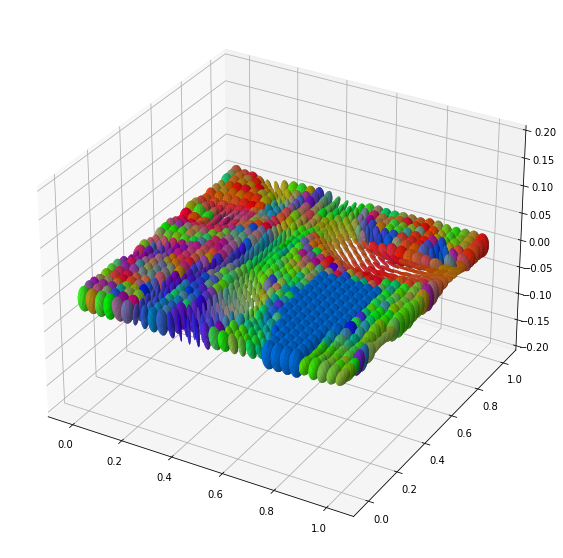

In [21]:
# Create Toy SPD dataset
from geomstats.geometry.spd_matrices import SPDMatrices

# Define the space and metric
DIM = 3
SPACE = SPDMatrices(DIM)
METRIC = SPACE.metric
gs.random.seed(0)


# Let’s try to visualize the tensor ellipsoids of a small rectangular area in an axial slice of the splenium of the corpus callosum (CC).
quadratic_forms = tenfit.quadratic_form[13:43, 44:74, 28:29]  # orig one

# Extract SPD-valued data from our DTI sample
t = gs.linspace(0, 1, quadratic_forms.shape[0])
X = gs.array(gs.meshgrid(t, t)).T.reshape(-1, 2)
indexes = gs.array(gs.meshgrid(gs.arange(quadratic_forms.shape[0]), gs.arange(quadratic_forms.shape[0]))).T.reshape(-1, 2)
y = gs.array([quadratic_forms[index[0] , index[1], 0] for index in indexes])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X)):
    plot_ellipsoid(ax, [X[i, 0], X[i, 1], 0], y[i])

ax.set_zlim(-.2,.2)
plt.show()

In [22]:
# Generate training set
X_train, y_train = gs.copy(X), gs.copy(y)

# Generate thinner time grid for "smooth" curve prediction at inference
n_samples_inference = 50
t_inference = gs.linspace(0, 1, n_samples_inference)
X_inference = gs.array(gs.meshgrid(t_inference, t_inference)).T.reshape(-1, 2)

In [23]:
# We use Frechet Mean as a priori
mean = FrechetMean(metric=METRIC)
mean.fit(y_train)
mean_estimate = mean.estimate_
prior = lambda X: mean_estimate
# RBF Kernel
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(.1, (1e-2, 1e-0))

In [24]:
# WGPR
wgp = WrappedGaussianProcess(space=SPACE, metric=METRIC, prior=prior, kernel=kernel)
wgp.fit(X_train, y_train)
y_pred = wgp.predict(X_inference)
y_inference_pred = wgp.predict(X_inference)

# Gaussian Process Regression
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train,y_train.reshape(-1, 3*3))  # reshaping because sklearn estimator doesn't accept n_dim > 2
y_inference_pred_gpr = gpr.predict(X_inference)
y_inference_pred_gpr = y_inference_pred_gpr.reshape(-1, 3, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Here again not all the GPR predictions are in the SPD manifold.

In [25]:
print("Percentage of GPR predictions belonging to the SPD manifold = ", gs.sum(SPACE.belongs(gs.array(y_inference_pred_gpr)))/len(y_inference_pred_gpr))

Percentage of GPR predictions belonging to the SPD manifold =  tensor(0.9452)


We finally plot the WGPR interpolation.

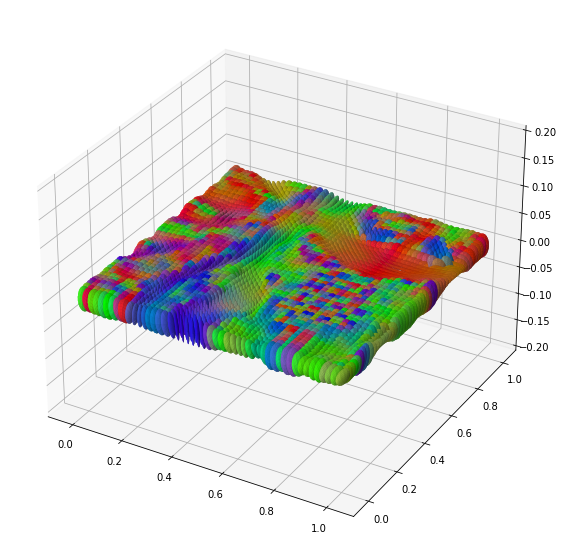

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(y_inference_pred)):
    plot_ellipsoid(ax, [X_inference[i, 0], X_inference[i, 1], 0], y_inference_pred[i])

ax.set_zlim(-.2,.2)
plt.show()



---



---



## References
- **[Fletcher2013]:** Fletcher, P.. (2013). Geodesic Regression and the Theory of Least Squares on Riemannian Manifolds. International Journal of Computer Vision. 105. 10.1007/s11263-012-0591-y.
-  **[Mallasto2018]:** Mallasto, Anton & Feragen, Aasa. (2018). Wrapped Gaussian Process Regression on Riemannian Manifolds. 5580-5588. 10.1109/CVPR.2018.00585.
- **[Rokem2015]:** Rokem A, Yeatman JD, Pestilli F, Kay KN, Mezer A, van der Walt S, and Wandell, BA. (2015) Evaluating the Accuracy of Diffusion MRI Models in White Matter. PLoS ONE 10(4): e0123272. doi:10.1371/journal.pone.0123272
- **[Pedregosa2011]:** Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." the Journal of machine Learning research 12 (2011): 2825-2830
- **[Miolane2020]:** Miolane, Nina, et al. "Geomstats: a Python package for Riemannian geometry in machine learning." Journal of Machine Learning Research 21.223 (2020): 1-9.
- **[Hinkle2012]:** Hinkle, Jacob et al. “Polynomial Regression on Riemannian Manifolds.” ECCV (2012). 

- **[Banerjee2015]:** Banerjee, Monami et al. “Nonlinear regression on Riemannian manifolds and its applications to Neuro-image analysis.” Medical image computing and computer-assisted intervention : MICCAI ... International Conference on Medical Image Computing and Computer-Assisted Intervention vol. 9349 (2015): 719-727. doi:10.1007/978-3-319-24553-9_88

 **[Davis2007]:** Davis, Bradley & Fletcher, P. & Bullitt, Elizabeth & Joshi, Sarang. (2007). Population Shape Regression From Random Design Data.. International Journal of Computer Vision. 90. 1-7. 10.1007/s11263-010-0367-1. 